# Imports

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
 
import P3_helpers as hlp
from P3_helpers import get_dataframe, get_parsed_comment, get_LDA_model, tokenize_one_comment, get_LDA_model_from_saved_file

import os
import json
import pickle
import dill
import matplotlib.pyplot as plt

nb_topics = range(3, 10, 2)
topic_positions = ['first', 'second', 'third', 'fourth', 'fifth']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Topic Modeling

## Loading and preprocessing DF

In [5]:
df = get_dataframe()
df.columns

Index(['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment'], dtype='object')

In [6]:
df['Parsed_Comment'] = df['Comment'].apply(get_parsed_comment)
df['Tokenized_Comment_not_filtered'] = df['Parsed_Comment'].apply(tokenize_one_comment)
df['BoW'] = hlp.get_bow_column(df['Tokenized_Comment_not_filtered'])


## Computing and saving topic models

In [7]:
isTrainSession = False

if isTrainSession:
    comments_series = df['Parsed_Comment'].copy(deep=True)
    topic_range = range(3, 10, 2)
    for nb_topics in topic_range:
        print(f"nb_topics: {nb_topics}")
        lda = get_LDA_model(comments_series=comments_series, num_topics=nb_topics, lemmatize=True)
        print(f"Saving model for {nb_topics} topics")
        lda.save(fname=f"lda_model_{nb_topics}_all_true_lemma")
        print(f"Topic_{nb_topics} done")

## Loading pre-computed models

In [8]:
models = []
nb_topics = range(3, 10, 2)

for nb_topic in nb_topics:
    models.append(get_LDA_model_from_saved_file(f"./topic_model_states_dict/lda_model_{nb_topic}_all_true_lemma"))

## Infer Topics by Comment

In [9]:
for i, model in enumerate(models):
    df[f'Topics_from_{nb_topics[i]}'] = df['BoW'].apply(model.get_document_topics)


In [10]:
new_save = True
if new_save:
    df.to_csv('df_with_topics_plus_lemma.csv', index=False)

In [11]:
for i, model in enumerate(models):
    d = model.print_topics(num_words=15)
    d = {topic[0]:topic[1] for topic in d}
    with open(f"topics_{nb_topics[i]}_dict_with_lemma.json", 'w') as f:
        json.dump(d,f)

--- 
# Statistics - basic

In [24]:
df = hlp.get_df_with_topics_from_csv(path='df_with_topics_plus_lemma.csv')
df = df[['Parsed_Comment', 'BoW', 'Topics_from_3', 'Topics_from_5', 'Topics_from_7', 'Topics_from_9']]

In [25]:
df_top_stat = hlp.get_topic_stat(df.copy(deep=True), nb_topics=nb_topics, topic_positions=topic_positions)
stats_dict = hlp.get_stats_dict_from_df_with_topics(df_top_stat, nb_topics=nb_topics, topic_positions=topic_positions)
with open('./jd_pie_charts/stats_dict_general.json', 'wb') as f:
    pickle.dump(stats_dict,f)

topics_dict = hlp.topic_dict_function(path_dir='./topic_dicts_wtih_lemma')
topic_description_dict = hlp.topic_str_plot(topics_dict)

with open('./topic_dicts_wtih_lemma/topic_description_dict_with_lemma.json', 'w') as f:
    json.dump(topic_description_dict,f)

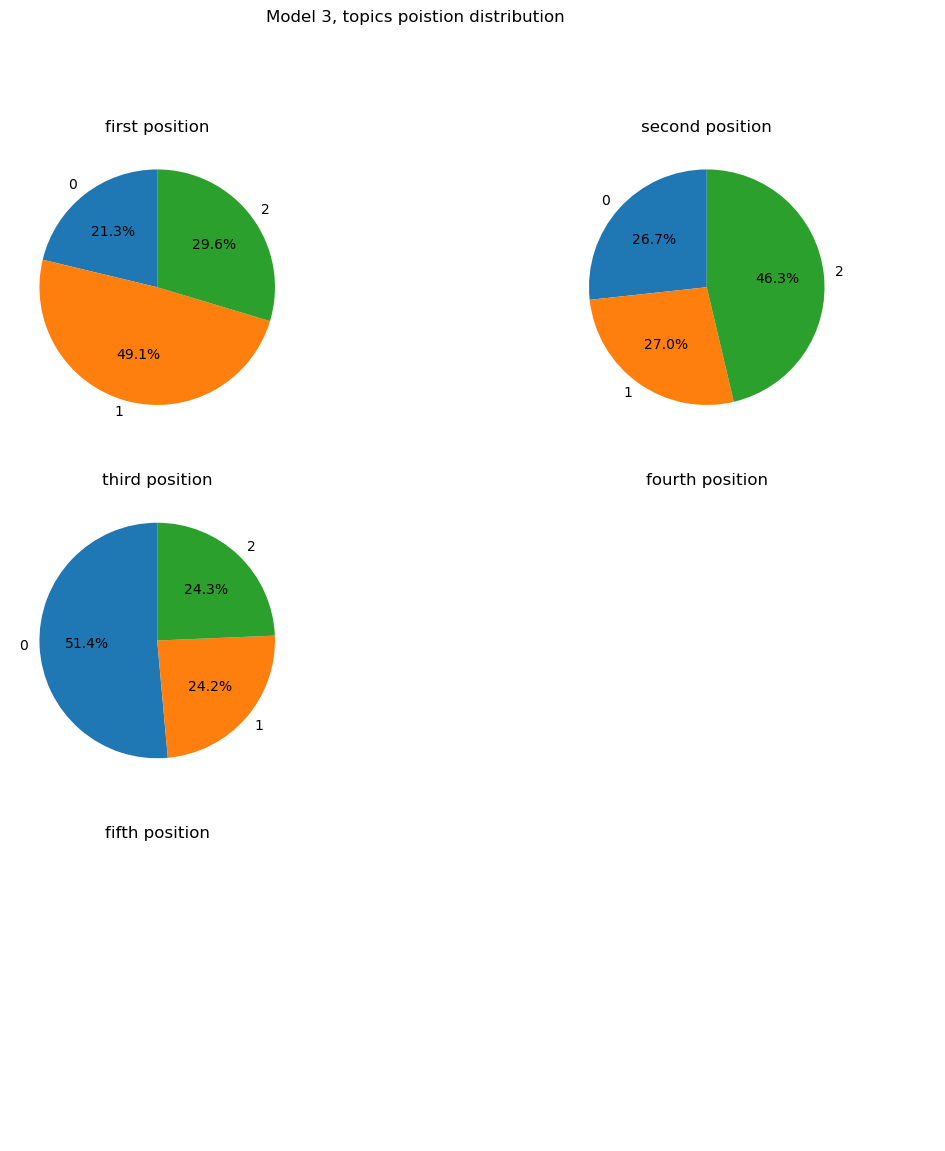

<Figure size 640x480 with 0 Axes>

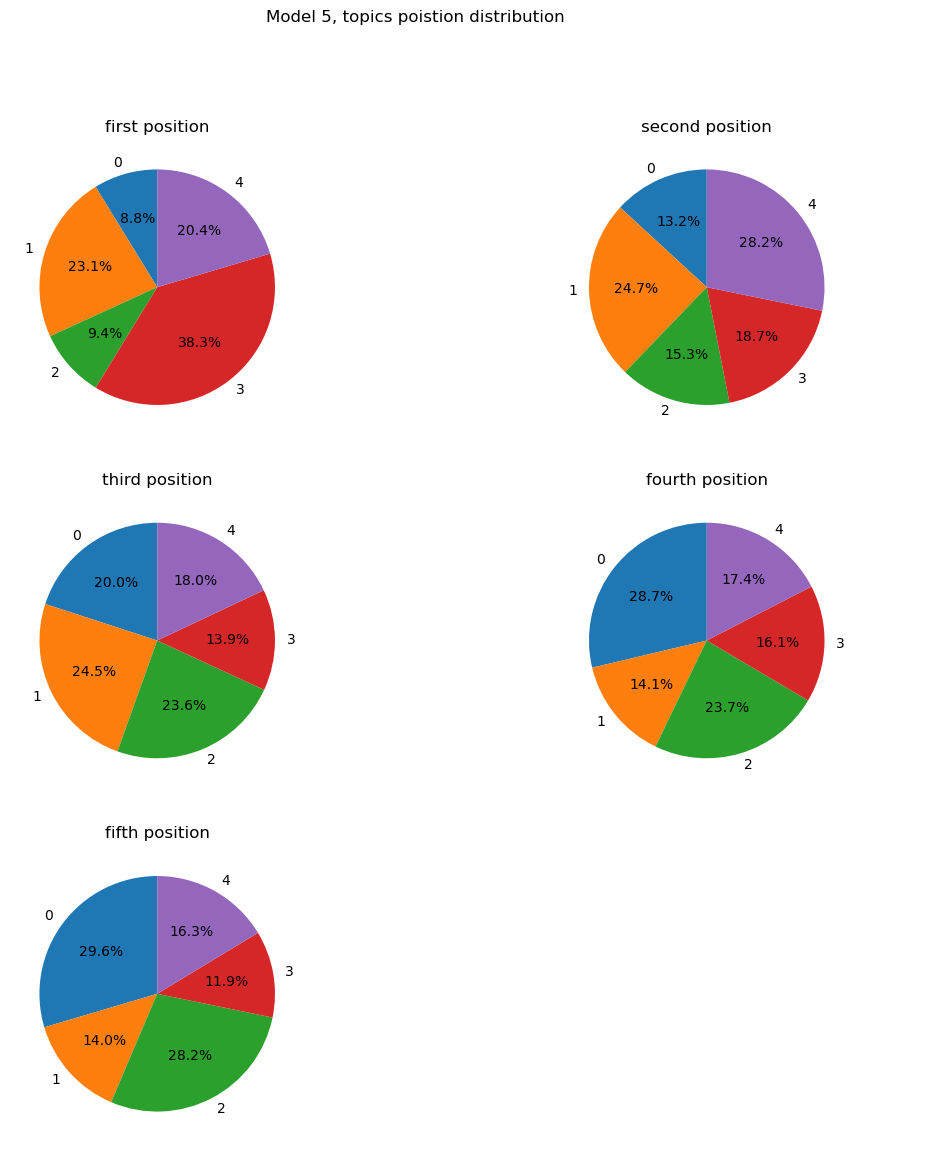

<Figure size 640x480 with 0 Axes>

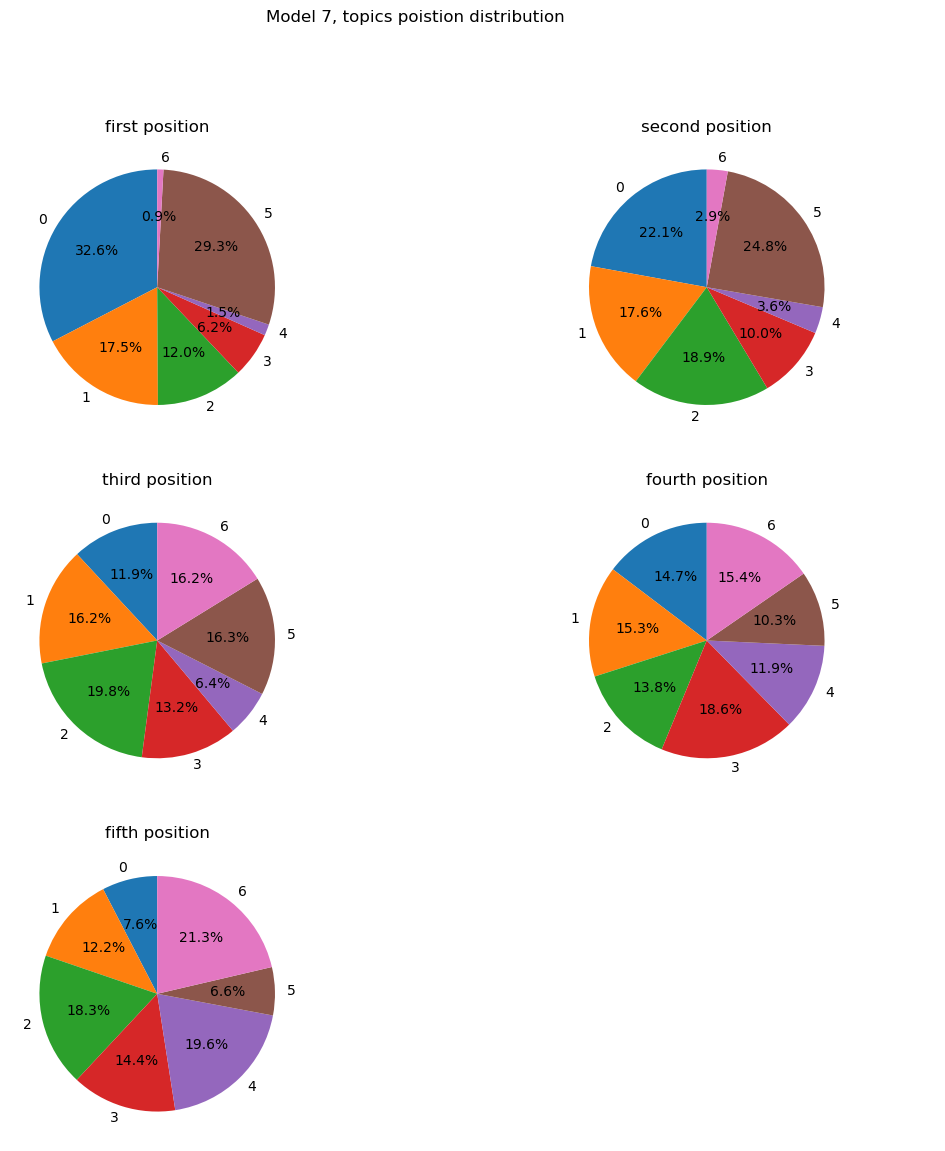

<Figure size 640x480 with 0 Axes>

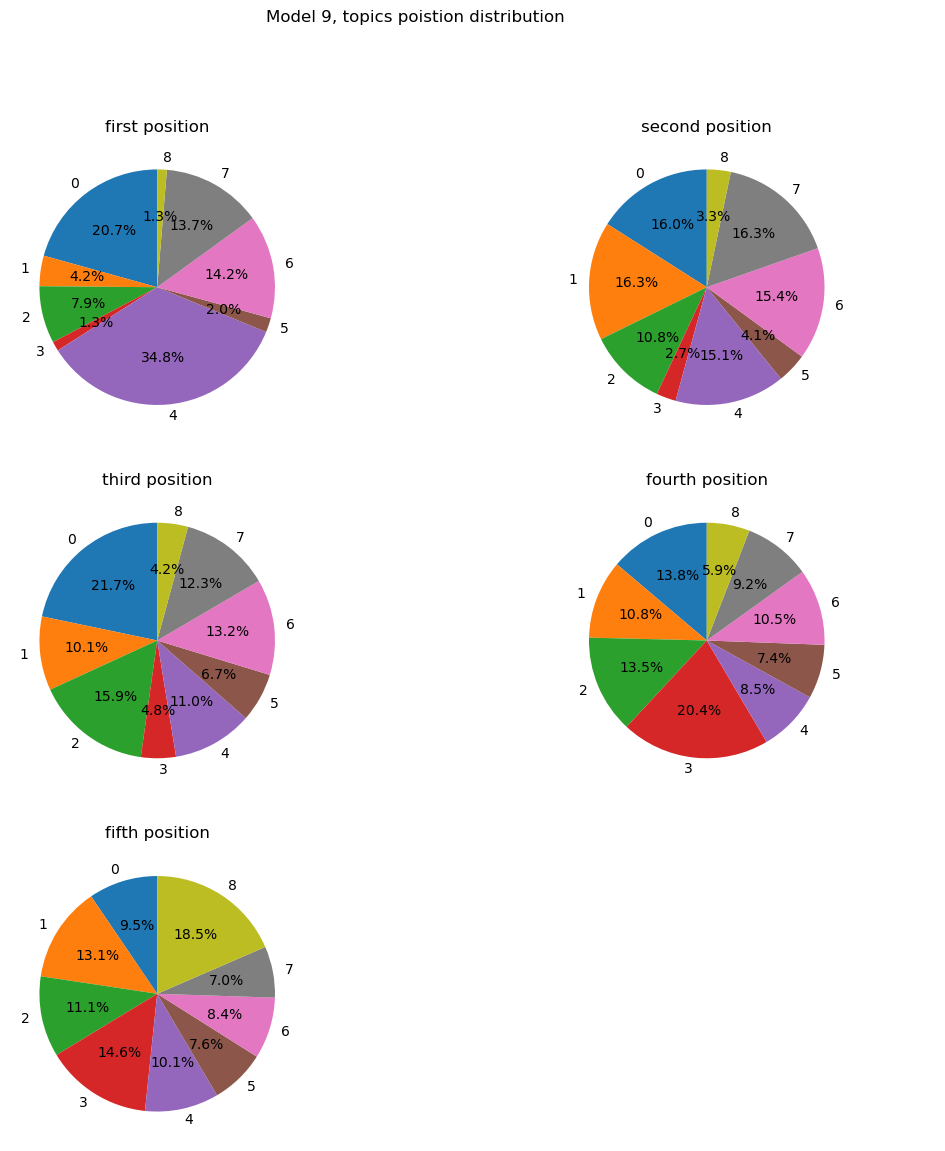

<Figure size 640x480 with 0 Axes>

In [26]:
def posIdx_to_axs_idx(i):
    return i//2, i%2

for nb_topic in nb_topics:
    fig, axs = plt.subplots(3, len(topic_positions)//2, figsize=(13, 13))
    fig.suptitle(f"Model {nb_topic}, topics poistion distribution")
    for i, pos in enumerate(topic_positions):
        ax = axs[posIdx_to_axs_idx(i)]
        df = stats_dict[(nb_topic, pos)]
        ax.pie(df[f"prob_of_topic_to_be_{pos}"], labels=df['Topic'].apply(lambda x: int(x)), autopct='%1.1f%%', shadow=False, startangle=90)
        ax.set_title(f"{pos} position")
    ax = axs[posIdx_to_axs_idx(i+1)]
    ax.axis('off')
    plt.show()
    plt.savefig(f"./jd_pie_charts/general/topic_{nb_topic}_distribution.png")

---
# Partie avec les communautés

In [ ]:
df_with_top_lem = hlp.get_df_with_topics_from_csv(path='df_with_topics_plus_lemma.csv') 
communities_dict = hlp.load_communities_dict_for_topic()

In [ ]:
df_with_top_lem = df_with_top_lem[['Source', 'Year', 'Comment', 'BoW',
                                   'Topics_from_3', 'Topics_from_5',
                                    'Topics_from_7', 'Topics_from_9',]]
df_with_top_lem.columns

In [ ]:
communities_topics_dict = hlp.join_left_com_top(df_with_top_lem.copy(deep=True), communities_dict)

In [ ]:
df_top_stat_com_dict = {}
for year, item in communities_topics_dict.items():
    for community, df in item.items():
        df_top_stat_com_dict[(year, community)] = hlp.get_topic_stat(df.copy(deep=True), nb_topics=nb_topics, topic_positions=topic_positions)

stats_dict_com = {}
for key, df in df_top_stat_com_dict.items():
    stats_dict_com[key] = hlp.get_stats_dict_from_df_with_topics(df, nb_topics=nb_topics, topic_positions=topic_positions)

with open('./jd_pie_charts/stats_dict_com.json', 'wb') as f:
    pickle.dump(stats_dict_com,f)

In [ ]:
def posIdx_to_axs_idx(i):
    return i//2, i%2

for key, stats_dict in stats_dict_com.items():
    year = key[0]
    community = key[1]
    for nb_topic in nb_topics:
        fig, axs = plt.subplots(3, len(topic_positions)//2, figsize=(13, 13))
        fig.suptitle(f"Year: {year}, Community: {community}, Model with {nb_topic} topics:")
        for i, pos in enumerate(topic_positions):
            ax = axs[posIdx_to_axs_idx(i)]
            df = stats_dict[(nb_topic, pos)]
            ax.pie(df[f"prob_of_topic_to_be_{pos}"], labels=df['Topic'], autopct='%1.1f%%', shadow=False, startangle=90)
            ax.set_title(f"{pos} position")
        ax = axs[posIdx_to_axs_idx(i+1)]
        ax.axis('off')
        plt.show()
        plt.savefig(f"./jd_pie_charts/communities/{year}_{community}_topic_{nb_topic}_distribution.png")